From https://docs.pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html

![LeNet-5 architecture](./lenet.png)

- Layer C1 is a convolutional layer, meaning that it scans the input image for features it learned during training. It outputs a map of where it saw each of its learned features in the image. This “activation map” is downsampled in layer S2.
- Layer C3 is another convolutional layer, this time scanning C1’s activation map for combinations of features. It also puts out an activation map describing the spatial locations of these feature combinations, which is downsampled in layer S4.
- Finally, the fully-connected layers at the end, F5, F6, and OUTPUT, are a classifier that takes the final activation map, and classifies it into one of ten bins representing the 10 digits


In [ ]:
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
USE_ACCELERATOR = False
DATA_PATH = "./data"
TORCH_SEED = 2147483647
SEED = 42

NUM_WORKERS_DATALOADER = 2
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1.0

# hyperparams
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
NUM_EPOCHS = 2


random.seed(SEED)
torch.manual_seed(TORCH_SEED)

device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available() and USE_ACCELERATOR
    else torch.device("cpu")
)
device

device(type='cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform)

# stack all train images together into a tensor of shape
# (50000, 3, 32, 32)
x = torch.stack([sample[0] for sample in data_utils.ConcatDataset([trainset])])
print(x.shape)

# get the mean of each channel
mean = torch.mean(x, dim=(0, 2, 3))
std = torch.std(x, dim=(0, 2, 3))
mean, std

torch.Size([50000, 3, 32, 32])


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [4]:
transform = transforms.Compose(
    # pillow to tensor, per-channel normalization so that it is gaussian (mean=0, std=1)
    [transforms.ToTensor(), transforms.Normalize(mean.tolist(), std.tolist())]
)
# 32x32 RGB images representing 10 classes
trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS_DATALOADER
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS_DATALOADER
)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47401398..1.5633934].


plane   cat  bird  frog


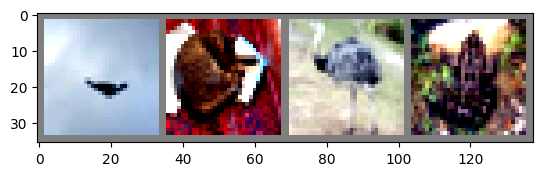

In [5]:
def imshow(img: torch.Tensor) -> None:
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(BATCH_SIZE)))

In [6]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # input is (N, 3, 32, 32) or (batch, in_channels, height, width)
        # for a 4-channel image, the kernel would also be (4, height, width) and fusing them:
        # output_value = (red_pixel × kernel[0]) +
        #                (green_pixel × kernel[1]) +
        #                (blue_pixel × kernel[2]) +
        #                (alpha_pixel × kernel[3])
        # 3 input channel (rgb), 6 output channels, 5x5 square conv kernel
        # each of the 6 kernels has shape (3, 5, 5)
        # each kernel slides over the 32x32 input, producing a total of 6 28x28 feature maps
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # subsampling: max pooling over (2, 2) kernel
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # (16, 5, 5) feature maps
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.flatten(start_dim=1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = LeNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
def train(
    dataloader: data_utils.DataLoader,
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    optimizer: torch.optim.Optimizer,
) -> None:
    size = len(dataloader.dataset)
    model.train()  # set train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # forward
        logits = model(X)
        loss = loss_fn(logits, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(
    dataloader: data_utils.DataLoader,
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            correct += (logits.argmax(dim=1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


test(testloader, model, loss_fn)

Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305910 



In [8]:
for t in range(NUM_EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.285244  [    4/50000]
loss: 2.235364  [  404/50000]
loss: 2.282487  [  804/50000]
loss: 2.251439  [ 1204/50000]
loss: 2.296719  [ 1604/50000]
loss: 2.239943  [ 2004/50000]
loss: 2.587330  [ 2404/50000]
loss: 2.191314  [ 2804/50000]
loss: 1.812452  [ 3204/50000]
loss: 1.837862  [ 3604/50000]
loss: 1.731631  [ 4004/50000]
loss: 1.767228  [ 4404/50000]
loss: 1.941388  [ 4804/50000]
loss: 0.799508  [ 5204/50000]
loss: 2.529079  [ 5604/50000]
loss: 2.293025  [ 6004/50000]
loss: 3.159275  [ 6404/50000]
loss: 2.409732  [ 6804/50000]
loss: 2.120778  [ 7204/50000]
loss: 1.474860  [ 7604/50000]
loss: 1.968125  [ 8004/50000]
loss: 1.918799  [ 8404/50000]
loss: 2.035982  [ 8804/50000]
loss: 1.986742  [ 9204/50000]
loss: 1.144441  [ 9604/50000]
loss: 2.701507  [10004/50000]
loss: 1.854996  [10404/50000]
loss: 2.254169  [10804/50000]
loss: 1.196310  [11204/50000]
loss: 1.795387  [11604/50000]
loss: 2.577806  [12004/50000]
loss: 1.717739  [12404/50000]
